In [1]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import pandas as pd
import os
from os import listdir
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from dataloader_teeth_analyst_stastic import *
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.nn import *
from EarlyStopping import EarlyStopping
from models import *
#from pytorchtools import EarlyStopping

In [2]:
class DeepConvNet(torch.nn.Module):
    def __init__(self, act_fn='ReLU'):
        super().__init__()
        
        dropout = 0.2
        self.conv0 = Conv2d(1, 32, kernel_size=(3, 3))
        self.conv1 = Conv2d(32, 32, kernel_size=(3, 3))
        self.layer1 = Sequential(
            BatchNorm2d(32),
            self.activationFunc(act_fn),
            MaxPool2d(kernel_size=(2, 2)),
            #Dropout2d(dropout)
        )

        self.conv2 = Conv2d(32, 64, kernel_size=(3, 3))
        self.layer2 = Sequential(
            BatchNorm2d(64),
            self.activationFunc(act_fn),
            MaxPool2d(kernel_size=(2, 2)),
            #Dropout(dropout)
        )
        
        self.conv3 = Conv2d(64, 128, kernel_size=(3, 3))
        self.layer3 = Sequential(
            BatchNorm2d(128),
            self.activationFunc(act_fn),
            MaxPool2d(kernel_size=(2, 2)),
            #Dropout(dropout)
        )
        
        self.conv4 = Conv2d(128, 128, kernel_size=(3, 3))
        self.layer4 = Sequential(
            BatchNorm2d(128),
            self.activationFunc(act_fn),
        )
        
        self.maxpool = Sequential(
            MaxPool2d(kernel_size=(2, 2)),
            #Dropout(dropout)
        )  

        self.fc1 = Sequential(
            Linear(in_features=8960,out_features=128),
            self.activationFunc(act_fn),
            Dropout(0.4)
        )

        self.fc2 = Sequential(
            Linear(in_features=128,out_features=64),
            self.activationFunc(act_fn),
            Dropout(0.2)
        )

        self.classify = Sequential(
            Linear(in_features=64,out_features=32),
        )


    def activationFunc(self, act_fn):
        if act_fn == 'ReLU':
            return ReLU()
        elif act_fn == 'LReLU':
            return LeakyReLU()
        else:
            return ELU()
        
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.conv2(x)
        x = self.layer2(x)
        x = self.conv3(x)
        x = self.layer3(x)
        x = self.conv4(x)
        x = self.layer4(x)
        
        h = x.register_hook(self.activations_hook)
        
        
        x = self.maxpool(x)
        #x = x.view(-1, 21504) # 當bug為 tensor_a(4).....tensor_b(8) -> //2 ->476800//2 (150,200)
        x = x.view(-1, 8960)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.classify(x)
        
        #print('final size =',x.size())
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.conv2(x)
        x = self.layer2(x)
        x = self.conv3(x)
        x = self.layer3(x)
        x = self.conv4(x)
        x = self.layer4(x)
        return x

print(DeepConvNet)

<class '__main__.DeepConvNet'>


In [3]:
%%time
batch_size = 16
train_dataset = GetDataset('','train')
val_dataset = GetDataset('','val')
test_dataset = GetDataset('','test',Istestori=True)
trainloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1,shuffle=False)
#train_data, valid_data = torch.utils.data.random_split(dataloader, [int(len(dataloader)*0.7), int(len(dataloader)*0.3)])
# for img,label in valid_data.dataset: # not only vali_data instead valid_data.dataset
#     print(label)
print('train :{}\t,test :{}\t,val :{}\t'.format(len(train_dataset),len(test_dataset),len(val_dataset)))

data length = 191040
class 1:	length :63
class 2:	length :1025
class 3:	length :1149
class 4:	length :1162
class 5:	length :1004
class 6:	length :1150
class 7:	length :1082
class 8:	length :977
class 9:	length :1021
class 10:	length :1113
class 11:	length :1112
class 12:	length :1003
class 13:	length :1153
class 14:	length :1205
class 15:	length :999
class 16:	length :81
class 17:	length :129
class 18:	length :862
class 19:	length :1042
class 20:	length :1119
class 21:	length :1185
class 22:	length :1018
class 23:	length :1024
class 24:	length :977
class 25:	length :934
class 26:	length :1051
class 27:	length :1000
class 28:	length :1182
class 29:	length :1130
class 30:	length :1032
class 31:	length :870
class 32:	length :146
> Found 30000 images...
data length = 191040
class 1:	length :24
class 2:	length :234
class 3:	length :289
class 4:	length :362
class 5:	length :272
class 6:	length :182
class 7:	length :327
class 8:	length :326
class 9:	length :318
class 10:	length :313
class 11:

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
import torchvision.models as models
model=DeepConvNet().to(device)
print(summary(model, (1, 200, 150)))
# model.eval()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 148]             320
            Conv2d-2         [-1, 32, 196, 146]           9,248
       BatchNorm2d-3         [-1, 32, 196, 146]              64
              ReLU-4         [-1, 32, 196, 146]               0
         MaxPool2d-5           [-1, 32, 98, 73]               0
            Conv2d-6           [-1, 64, 96, 71]          18,496
       BatchNorm2d-7           [-1, 64, 96, 71]             128
              ReLU-8           [-1, 64, 96, 71]               0
         MaxPool2d-9           [-1, 64, 48, 35]               0
           Conv2d-10          [-1, 128, 46, 33]          73,856
      BatchNorm2d-11          [-1, 128, 46, 33]             256
             ReLU-12          [-1, 128, 46, 33]               0
        MaxPool2d-13          [-1, 128, 23, 16]               0
           Conv2d-14          [-1, 128,

In [6]:
import torchvision.models as models
def train(trainloader,valloader,epochs,learning_rate, patience):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    # model
#     model=DeepConvNet().to(device)
    model = models.inception_v3()#.to(device)
    model.Conv2d_1a_3x3.conv = Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    model.fc = Linear(in_features=2048, out_features=32, bias=True)
    model = model.to(device)
    
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-3)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    #optimizer = optim.Adadelta(model.parameters())
    criterion = CrossEntropyLoss()

    train_acc=[]
    train_loss=[]
    
    val_acc=[]
    val_loss=[]
    
    total = 0
    correct = 0

    eval_total = 0
    eval_correct = 0
    
    max_vacc = 0
    
    print("Starting the training loop from epoch {}".format(0))
    
    for epoch in range(epochs):
        model.train()
        print('train')
        running_loss = 0
        total = 0
        correct = 0
        for data in tqdm(trainloader):
            
            # input
            x, y = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.int64)
#             print(x.shape)
            optimizer.zero_grad()
    
#             output = model(x) # forward
            
#===============================================================
            #output = model(x).logits # for inception model
            output, aux_outputs = model(x)
            loss1 = criterion(output, y)
            loss2 = criterion(aux_outputs, y)
            loss = loss1 + 0.4*loss2
            _, predicted = torch.max(output, 1)
            
 #=======================================================           
            
            #Calculate accuracy
            max_value, predicted = torch.max(output.data, 1)
            total += y.size(0) #batch_size
            correct += (predicted == y).sum().item()
            
            #loss = criterion(output, y) #loss
            
#             regularization_loss = 0
#             for parma in model.parameters():
#                 regularization_loss += torch.sum(torch.abs(parma))
#             loss = loss + 0.0001*regularization_loss
            
            loss.backward() # backward
            optimizer.step()
            
            running_loss += loss.item()
        
        tloss=running_loss/len(trainloader)
        train_loss.append(tloss)
        
        tacc = correct/total
        train_acc.append(tacc)
        
        #==========eval===========
        model.eval()
#        print('eval')
        eval_total = 0
        eval_correct = 0
        val_running_loss = 0
        for data in tqdm(valloader):
            # input
            x, y = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.int64)
#             optimizer.zero_grad()
            output = model(x) # forward
            #Calculate accuracy
            max_value, predicted = torch.max(output.data, 1)
            eval_total += y.size(0) #batch_size
            eval_correct += (predicted == y).sum().item()
            
            loss = criterion(output, y) #loss
            
            val_running_loss += loss.item()
        
        vloss=val_running_loss/len(valloader)
        val_loss.append(vloss)
        
        eval_acc = eval_correct/eval_total
        val_acc.append(eval_acc)
        
        if max_vacc < eval_acc:
            max_vacc = eval_acc
            torch.save(model, 'model/'+'best'+'.pkl')
        
        print('Epoch[%d] Loss: %.4f'% (epoch+1, tloss))
        print('Epoch[%d] Acc: %.4f'% (epoch+1, tacc))
        print('Epoch[%d] eval_Acc: %.4f'% (epoch+1, eval_acc))        
        
        #torch.save(model, 'model/'+str(int(tacc*100))+'.pkl')
        if int(eval_acc*100) >= 70:
            torch.save(model, 'model/'+str(int(eval_acc*100))+'.pkl')
            
#         early_stopping(vloss, model)
#         if early_stopping.early_stop:
#             torch.save(model, 'model/'+'last_early'+'.pkl')
#             print("Early stopping")
#             break
        
    print('max_eval_acc =,',max_vacc)
    return train_acc,train_loss,val_acc,val_loss

In [12]:
%%time
n_epochs = 100
patience = 20
train_acc,train_loss,val_acc,val_loss = train(trainloader,valloader,n_epochs,0.001, patience)

Starting the training loop from epoch 0
train


C:\Users\lab118\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\lab118\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch[1] Loss: 3.6049
Epoch[1] Acc: 0.1748
Epoch[1] eval_Acc: 0.2976
train


C:\Users\lab118\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Inception3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\lab118\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BasicConv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\lab118\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\lab118\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked 


Epoch[2] Loss: 2.2058
Epoch[2] Acc: 0.4060
Epoch[2] eval_Acc: 0.4948
train



Epoch[3] Loss: 1.5643
Epoch[3] Acc: 0.5770
Epoch[3] eval_Acc: 0.5704
train



Epoch[4] Loss: 1.1773
Epoch[4] Acc: 0.6915
Epoch[4] eval_Acc: 0.6481
train



Epoch[5] Loss: 0.8818
Epoch[5] Acc: 0.7747
Epoch[5] eval_Acc: 0.6936
train



Epoch[6] Loss: 0.6563
Epoch[6] Acc: 0.8371
Epoch[6] eval_Acc: 0.6859
train



Epoch[7] Loss: 0.4824
Epoch[7] Acc: 0.8834
Epoch[7] eval_Acc: 0.7145
train



Epoch[8] Loss: 0.3487
Epoch[8] Acc: 0.9180
Epoch[8] eval_Acc: 0.6966
train



Epoch[9] Loss: 0.2762
Epoch[9] Acc: 0.9379
Epoch[9] eval_Acc: 0.7309
train



Epoch[10] Loss: 0.2056
Epoch[10] Acc: 0.9559
Epoch[10] eval_Acc: 0.7219
train



Epoch[11] Loss: 0.1600
Epoch[11] Acc: 0.9682
Epoch[11] eval_Acc: 0.7218
train



Epoch[12] Loss: 0.1347
Epoch[12] Acc: 0.9729
Epoch[12] eval_Acc: 0.7379
train



Epoch[13] Loss: 0.1018
Epoch[13] Acc: 0.9830
Epoch[13] eval_Acc: 0.7425
train



Epoch[14] Loss: 0.0903
Epoch[14] Acc: 0.9849
Epoch[14] eval_Acc: 0.7385
train



Epoch[15] Loss: 0.0745
Epoch[15] Acc: 0.9888
Epoch[15] eval_Acc: 0.7422
train



Epoch[16] Loss: 0.0625
Epoch[16] Acc: 0.9912
Epoch[16] eval_Acc: 0.7339
train



Epoch[17] Loss: 0.0639
Epoch[17] Acc: 0.9900
Epoch[17] eval_Acc: 0.7570
train



Epoch[18] Loss: 0.0577
Epoch[18] Acc: 0.9918
Epoch[18] eval_Acc: 0.7664
train



Epoch[19] Loss: 0.0517
Epoch[19] Acc: 0.9925
Epoch[19] eval_Acc: 0.7402
train



Epoch[20] Loss: 0.0513
Epoch[20] Acc: 0.9934
Epoch[20] eval_Acc: 0.7700
train



Epoch[21] Loss: 0.0404
Epoch[21] Acc: 0.9956
Epoch[21] eval_Acc: 0.7518
train



Epoch[22] Loss: 0.0420
Epoch[22] Acc: 0.9953
Epoch[22] eval_Acc: 0.7325
train



Epoch[23] Loss: 0.0409
Epoch[23] Acc: 0.9956
Epoch[23] eval_Acc: 0.7621
train



Epoch[24] Loss: 0.0328
Epoch[24] Acc: 0.9974
Epoch[24] eval_Acc: 0.7629
train



Epoch[25] Loss: 0.0364
Epoch[25] Acc: 0.9963
Epoch[25] eval_Acc: 0.7548
train



Epoch[26] Loss: 0.0329
Epoch[26] Acc: 0.9975
Epoch[26] eval_Acc: 0.7721
train



Epoch[27] Loss: 0.0419
Epoch[27] Acc: 0.9955
Epoch[27] eval_Acc: 0.7711
train



Epoch[28] Loss: 0.0390
Epoch[28] Acc: 0.9958
Epoch[28] eval_Acc: 0.7484
train



Epoch[29] Loss: 0.0297
Epoch[29] Acc: 0.9981
Epoch[29] eval_Acc: 0.7810
train



Epoch[30] Loss: 0.0349
Epoch[30] Acc: 0.9972
Epoch[30] eval_Acc: 0.7628
train



Epoch[31] Loss: 0.0362
Epoch[31] Acc: 0.9962
Epoch[31] eval_Acc: 0.7612
train



Epoch[32] Loss: 0.0449
Epoch[32] Acc: 0.9949
Epoch[32] eval_Acc: 0.7621
train



Epoch[33] Loss: 0.0434
Epoch[33] Acc: 0.9949
Epoch[33] eval_Acc: 0.7336
train



Epoch[34] Loss: 0.0484
Epoch[34] Acc: 0.9942
Epoch[34] eval_Acc: 0.7656
train



Epoch[35] Loss: 0.0345
Epoch[35] Acc: 0.9966
Epoch[35] eval_Acc: 0.7646
train



Epoch[36] Loss: 0.0440
Epoch[36] Acc: 0.9948
Epoch[36] eval_Acc: 0.7562
train



Epoch[37] Loss: 0.0545
Epoch[37] Acc: 0.9932
Epoch[37] eval_Acc: 0.7679
train



Epoch[38] Loss: 0.0489
Epoch[38] Acc: 0.9940
Epoch[38] eval_Acc: 0.7601
train



Epoch[39] Loss: 0.0341
Epoch[39] Acc: 0.9972
Epoch[39] eval_Acc: 0.7789
train



Epoch[40] Loss: 0.0373
Epoch[40] Acc: 0.9961
Epoch[40] eval_Acc: 0.7529
train



Epoch[41] Loss: 0.0382
Epoch[41] Acc: 0.9964
Epoch[41] eval_Acc: 0.7865
train



Epoch[42] Loss: 0.0549
Epoch[42] Acc: 0.9924
Epoch[42] eval_Acc: 0.7738
train



Epoch[43] Loss: 0.0429
Epoch[43] Acc: 0.9957
Epoch[43] eval_Acc: 0.7741
train



Epoch[44] Loss: 0.0327
Epoch[44] Acc: 0.9972
Epoch[44] eval_Acc: 0.7814
train



Epoch[45] Loss: 0.0490
Epoch[45] Acc: 0.9942
Epoch[45] eval_Acc: 0.7619
train



Epoch[46] Loss: 0.0398
Epoch[46] Acc: 0.9958
Epoch[46] eval_Acc: 0.7919
train



Epoch[47] Loss: 0.0315
Epoch[47] Acc: 0.9975
Epoch[47] eval_Acc: 0.7661
train



Epoch[48] Loss: 0.0347
Epoch[48] Acc: 0.9967
Epoch[48] eval_Acc: 0.7615
train



Epoch[49] Loss: 0.0639
Epoch[49] Acc: 0.9907
Epoch[49] eval_Acc: 0.7744
train



Epoch[50] Loss: 0.0700
Epoch[50] Acc: 0.9897
Epoch[50] eval_Acc: 0.7096
train



Epoch[51] Loss: 0.0739
Epoch[51] Acc: 0.9881
Epoch[51] eval_Acc: 0.7655
train



Epoch[52] Loss: 0.0586
Epoch[52] Acc: 0.9917
Epoch[52] eval_Acc: 0.7796
train



Epoch[53] Loss: 0.0371
Epoch[53] Acc: 0.9963
Epoch[53] eval_Acc: 0.7860
train



Epoch[54] Loss: 0.0438
Epoch[54] Acc: 0.9943
Epoch[54] eval_Acc: 0.7592
train



Epoch[55] Loss: 0.0554
Epoch[55] Acc: 0.9928
Epoch[55] eval_Acc: 0.7640
train



Epoch[56] Loss: 0.0569
Epoch[56] Acc: 0.9921
Epoch[56] eval_Acc: 0.7846
train



Epoch[57] Loss: 0.0671
Epoch[57] Acc: 0.9899
Epoch[57] eval_Acc: 0.7430
train



Epoch[58] Loss: 0.0552
Epoch[58] Acc: 0.9923
Epoch[58] eval_Acc: 0.7455
train



Epoch[59] Loss: 0.0562
Epoch[59] Acc: 0.9921
Epoch[59] eval_Acc: 0.7395
train



Epoch[60] Loss: 0.0506
Epoch[60] Acc: 0.9930
Epoch[60] eval_Acc: 0.7380
train



Epoch[61] Loss: 0.0466
Epoch[61] Acc: 0.9936
Epoch[61] eval_Acc: 0.7704
train



Epoch[62] Loss: 0.0506
Epoch[62] Acc: 0.9929
Epoch[62] eval_Acc: 0.7708
train



Epoch[63] Loss: 0.0458
Epoch[63] Acc: 0.9942
Epoch[63] eval_Acc: 0.7536
train



Epoch[64] Loss: 0.0524
Epoch[64] Acc: 0.9931
Epoch[64] eval_Acc: 0.7849
train



Epoch[65] Loss: 0.0309
Epoch[65] Acc: 0.9970
Epoch[65] eval_Acc: 0.7830
train



Epoch[66] Loss: 0.0491
Epoch[66] Acc: 0.9933
Epoch[66] eval_Acc: 0.7789
train



Epoch[67] Loss: 0.0621
Epoch[67] Acc: 0.9902
Epoch[67] eval_Acc: 0.7568
train



Epoch[68] Loss: 0.0658
Epoch[68] Acc: 0.9898
Epoch[68] eval_Acc: 0.7752
train



Epoch[69] Loss: 0.0634
Epoch[69] Acc: 0.9899
Epoch[69] eval_Acc: 0.7686
train



Epoch[70] Loss: 0.0708
Epoch[70] Acc: 0.9877
Epoch[70] eval_Acc: 0.7751
train



Epoch[71] Loss: 0.0495
Epoch[71] Acc: 0.9935
Epoch[71] eval_Acc: 0.7876
train



Epoch[72] Loss: 0.0603
Epoch[72] Acc: 0.9910
Epoch[72] eval_Acc: 0.7625
train



Epoch[73] Loss: 0.0657
Epoch[73] Acc: 0.9898
Epoch[73] eval_Acc: 0.7691
train



Epoch[74] Loss: 0.0493
Epoch[74] Acc: 0.9934
Epoch[74] eval_Acc: 0.7574
train



Epoch[75] Loss: 0.0643
Epoch[75] Acc: 0.9903
Epoch[75] eval_Acc: 0.7668
train



Epoch[76] Loss: 0.0385
Epoch[76] Acc: 0.9955
Epoch[76] eval_Acc: 0.7927
train



Epoch[77] Loss: 0.0583
Epoch[77] Acc: 0.9912
Epoch[77] eval_Acc: 0.7436
train



Epoch[78] Loss: 0.0791
Epoch[78] Acc: 0.9870
Epoch[78] eval_Acc: 0.7836
train



Epoch[79] Loss: 0.0419
Epoch[79] Acc: 0.9948
Epoch[79] eval_Acc: 0.7841
train



Epoch[80] Loss: 0.0235
Epoch[80] Acc: 0.9983
Epoch[80] eval_Acc: 0.8034
train



Epoch[81] Loss: 0.0232
Epoch[81] Acc: 0.9981
Epoch[81] eval_Acc: 0.7619
train



Epoch[82] Loss: 0.0953
Epoch[82] Acc: 0.9839
Epoch[82] eval_Acc: 0.7474
train



Epoch[83] Loss: 0.0868
Epoch[83] Acc: 0.9857
Epoch[83] eval_Acc: 0.7561
train



Epoch[84] Loss: 0.0752
Epoch[84] Acc: 0.9883
Epoch[84] eval_Acc: 0.7133
train



Epoch[85] Loss: 0.0618
Epoch[85] Acc: 0.9909
Epoch[85] eval_Acc: 0.7764
train



Epoch[86] Loss: 0.0566
Epoch[86] Acc: 0.9912
Epoch[86] eval_Acc: 0.7870
train



Epoch[87] Loss: 0.0897
Epoch[87] Acc: 0.9838
Epoch[87] eval_Acc: 0.6983
train



Epoch[88] Loss: 0.0523
Epoch[88] Acc: 0.9929
Epoch[88] eval_Acc: 0.7232
train



Epoch[89] Loss: 0.0646
Epoch[89] Acc: 0.9902
Epoch[89] eval_Acc: 0.7781
train



Epoch[90] Loss: 0.0576
Epoch[90] Acc: 0.9909
Epoch[90] eval_Acc: 0.7819
train



Epoch[91] Loss: 0.0613
Epoch[91] Acc: 0.9907
Epoch[91] eval_Acc: 0.7578
train



Epoch[92] Loss: 0.0503
Epoch[92] Acc: 0.9925
Epoch[92] eval_Acc: 0.7582
train


KeyboardInterrupt: 

# Plot

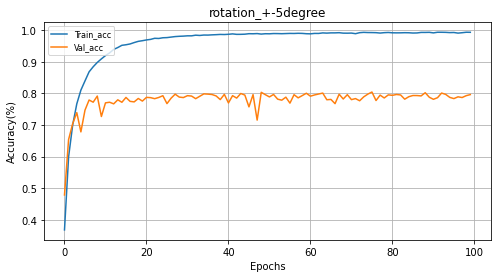

In [8]:
fig = plt.figure(figsize=(8,4))
plt.plot(train_acc,label='Train_acc')
plt.plot(val_acc,label='Val_acc')
plt.grid(True)
plt.title('rotation_+-5degree')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.legend(loc='upper left',fontsize=8)
plt.savefig('0830degree_acc.png')

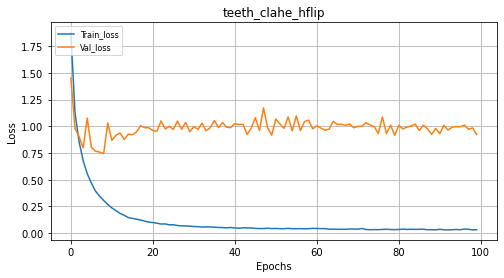

In [9]:
fig = plt.figure(figsize=(8,4))
plt.plot(train_loss,label='Train_loss')
plt.plot(val_loss,label='Val_loss')
plt.grid(True)
plt.title('teeth_clahe_hflip')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left',fontsize=8)
plt.savefig('0830degree_loss.png')

# Load Model

In [13]:
model = torch.load('./model/best.pkl')

batch_size = 1
#train_dataset = GetDataset('D:/gpstrack_video/jpg',100)
#testloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
# test_dataset = GetDataset('','test')
# testloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

test_dataset = GetDataset('','test',Istestori=True)
testloader = DataLoader(test_dataset, batch_size=1,shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

total = 0
correct = 0
targets = []
preds = []
test_path = []
for i, data in tqdm(enumerate(testloader)):
    x, y, img_path = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.int64), data[2]
    #test_path = test_path.append(data[2])

    output = model(x)
    max_value, predicted = torch.max(output.data, 1)
#     print('label =',y)
#     print('pred  =',predicted)
#     if y.cpu().numpy()[0]+1==3:
#         if predicted.cpu().numpy()[0]+1==19:
#             print('img_path =',img_path)
#             img = PIL.Image.open(img_path[0]).convert('RGB')
            
    total += y.size(0) #batch_size
    correct += (predicted == y).sum().item()
    
    targets.extend(y.view_as(predicted))
    preds.extend(predicted)
    
print('Maxacc : %.4f'%(100*correct/total))

data length = 9552
class 1:	length :6
class 2:	length :69
class 3:	length :60
class 4:	length :81
class 5:	length :73
class 6:	length :79
class 7:	length :73
class 8:	length :74
class 9:	length :74
class 10:	length :73
class 11:	length :79
class 12:	length :73
class 13:	length :81
class 14:	length :60
class 15:	length :69
class 16:	length :6
class 17:	length :9
class 18:	length :56
class 19:	length :52
class 20:	length :67
class 21:	length :90
class 22:	length :66
class 23:	length :87
class 24:	length :58
class 25:	length :58
class 26:	length :87
class 27:	length :66
class 28:	length :90
class 29:	length :67
class 30:	length :52
class 31:	length :56
class 32:	length :9
> Found 2000 images...


C:\Users\lab118\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Maxacc : 81.3000


# Show confusion matrix

In [40]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    
    confusion = confusion_matrix(y_true, y_pred)
    classes = [i for i in range(1,33)]
    confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis] #normalize
    
    
    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(confusion.shape[1]),
           yticks=np.arange(confusion.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    fmt = '.2f'
    thresh = confusion.max() / 2.
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            ax.text(j, i, format(confusion[i, j], fmt),
                    ha="center", va="center",
                    color="white" if confusion[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(title + ".png")
    plt.clf()
    plt.cla()
    plt.close()
    
    return ax

In [12]:
print(type(targets))
targets_val = torch.stack(targets)
preds_val = torch.stack(preds)
plot_confusion_matrix(targets_val.cpu().numpy(), preds_val.cpu().numpy(),'0831_confusion')

<class 'list'>


# Cam

In [12]:
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def plot_heatmap(heatmap, img_path, label, pred_class_name,title):
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    
    fig, ax = plt.subplots(1,2,figsize=(7,7))
    #fig2, ax2 = plt.subplots(figsize=(7,7))
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path,0), cv2.COLOR_GRAY2RGB), (img.shape[3], img.shape[2])).astype(np.uint8)
    
    if label < 16:
        im = cv2.flip(im, 0)

    heatmap = cv2.resize(heatmap, (img.shape[3], img.shape[2]))
    heatmap = np.uint8(255 * heatmap)
    
    ax[0].imshow(im)
    ax[1].imshow(im, alpha=0.7)
    ax[1].imshow(heatmap, cmap='jet', alpha=0.3)
    
    plt.title(pred_class_name)
    plt.savefig('./cam/'+title + ".png")
    #plt.show()

C:\Users\lab118\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


path = ('Dental_Data/PBL/PBL_addname/10_clahe_20200810_addname_1/03-58-49-726_600872 041519 x_NN_190415_142436_15BF46_5_-7F.png',)
truth = 5
predicted = 27
T/F = F

Wall time: 33.6 s


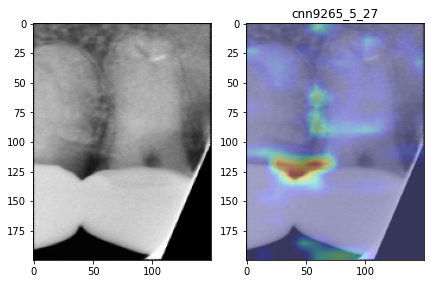

In [14]:
%%time
for idx, data in tqdm(enumerate(testloader)):
    img, label, img_path = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.int64), data[2]
#     print('label =',label)
#     print('path  =',img_path[0])
    if '03-58-49-726_600872 041519 x_NN_190415_142436_15BF46_5' not in img_path[0]:
        continue
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(img).detach()
    for i in range(128):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu(), 0)
    #plt.matshow(heatmap.squeeze())
    #################pred
    output = model(img)
    max_value, predicted = torch.max(output.data, 1)
    print('path =',img_path)
    print('truth =',label.cpu().numpy()[0]+1)
    print('predicted =',predicted.cpu().numpy()[0]+1)
    if label.cpu().numpy()[0]+1 == predicted.cpu().numpy()[0]+1:
        print('T/F = T')
    else:
        print('T/F = F')
    #########################
    # print('heatmap shape =',np.shape(heatmap))
    # heatmap /= torch.max(heatmap)
    pred_class_name = 'cnn'+str(idx)+'_'+str(label.cpu().numpy()[0]+1)+'_'+str(predicted.cpu().numpy()[0]+1)
    plot_heatmap(heatmap.cpu().numpy(), img_path[0], label.cpu().numpy()[0], pred_class_name,pred_class_name)
        
        
        

# test for one folder

In [ ]:
new_size = (200,150)
for i in range(1,33):
    if i <= 16:
        trans_method = [
            transforms.Resize(new_size),
            transforms.RandomVerticalFlip(p=1),
            transforms.Grayscale(),
            transforms.ToTensor()
        ]
    else:
        trans_method = [
            transforms.Resize(new_size),
            transforms.Grayscale(),
            transforms.ToTensor()
        ]
    trans = transforms.Compose(trans_method)
    img_path = 'Dental_Data/PBL/678372/'+str(i)+'.png'
    if not os.path.isfile(img_path):
        continue
    img = PIL.Image.open(img_path).convert('RGB')
    img = trans(img)
    img = img.to(device)
    img.unsqueeze_(0)
    output = model(img)
    max_value, predicted = torch.max(output.data, 1)
    print('path =',img_path)
    print('truth =',i)
    print('predicted =',predicted.cpu().numpy()[0]+1)

# Create test consecutive data in dental radiograph

In [7]:
count = 0
df = pd.DataFrame(columns=['folder','image','label','predict','total_path'])
for idx, data in tqdm(enumerate(testloader)):
    img, label, img_path = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.int64), data[2]
    if img_path[0][-5] == 'F':
        continue
    x, y = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.int64)
    output = model(x)
    max_value, predicted = torch.max(output.data, 1)
    
    if len(img_path[0].split('_'))==14:
        foloder = img_path[0].split('_')[-7]
    if len(img_path[0].split('_'))==15:
        foloder = img_path[0].split('_')[-8] + '_' + img_path[0].split('_')[-7]
        
    image = img_path[0].split('_')[-3]
    label = label.cpu().numpy()[0]+1
    predict = predicted.cpu().numpy()[0]+1
    df.loc[count] = [foloder, image, label, predict, img_path[0]]
    count += 1
    #print('img_path =',img_path[0])

df = df.set_index(keys = ['folder','image'])
df.sort_values(['folder', 'image','label'],inplace=True)
###########正的先做 -> if img_path[0][-5] == 'F':continue 在做flip ->手動concanate
#df.to_csv('all_teeth_sort_flip_2.csv')
#df = pd.read_csv('all_teeth_comparewith_flip.csv')
################################

for idx in df.index.unique():
    if df.loc[idx]['label'][0] > 16:
        df.loc[idx] = df.loc[idx].sort_values(['folder', 'image','label'],ascending=[True, True, False])
#df.to_csv('0824_only_nonflip.csv')
df.to_csv('all_label_in_the_same_folder.csv')
df

C:\Users\lab118\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


label predict  \
folder             image                  
000408 102419 x    BE78A8     6      16   
                   BE78A8     7       4   
                   BE78A9    10      22   
                   BE78AB    26      22   
                   BE78AB    25      10   
...                         ...     ...   
710456 111119 x_NN 2420D     14      32   
                   2420D     15      16   
                   2420E     21      20   
                   2420E     20      10   
                   24211      7      10   

                                                                  total_path  
folder             image                                                      
000408 102419 x    BE78A8  Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   BE78A8  Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   BE78A9  Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   BE78AB  Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   BE78AB  Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
...                                                                      ...  
710456 111119 x_NN 2420D   Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   2420D   Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   2420E   Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   2420E   Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   24211   Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  

[4776 rows x 3 columns]

In [8]:
len_dataframe = pd.DataFrame(columns=['folder','image','length'])
for idx, folder_image in enumerate(df.index.unique()):
    len_dataframe.loc[idx] = [folder_image[0],folder_image[1],len(df.loc[folder_image])]
len_dataframe = len_dataframe.set_index(keys = ['folder','image'])
len_dataframe.to_csv('all_label_in_the_same_folder_len_dataframe.csv')
len_dataframe

length
folder             image        
000408 102419 x    BE78A8      2
                   BE78A9      1
                   BE78AB      3
                   BE78AD      2
                   BE78AE      1
...                          ...
710456 111119 x_NN 2420A       3
                   2420C       2
                   2420D       3
                   2420E       2
                   24211       1

[2077 rows x 1 columns]

# Algorithm

In [9]:
len_dataframe = pd.read_csv('all_label_in_the_same_folder_len_dataframe.csv')
len_dataframe = len_dataframe.set_index(keys = ['folder','image'])
df = pd.read_csv('all_label_in_the_same_folder.csv')
df = df.set_index(keys = ['folder','image'])
df

label  predict  \
folder             image                    
000408 102419 x    BE78A8      6       16   
                   BE78A8      7        4   
                   BE78A9     10       22   
                   BE78AB     26       22   
                   BE78AB     25       10   
...                          ...      ...   
710456 111119 x_NN 2420D      14       32   
                   2420D      15       16   
                   2420E      21       20   
                   2420E      20       10   
                   24211       7       10   

                                                                  total_path  
folder             image                                                      
000408 102419 x    BE78A8  Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   BE78A8  Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   BE78A9  Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   BE78AB  Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   BE78AB  Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
...                                                                      ...  
710456 111119 x_NN 2420D   Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   2420D   Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   2420E   Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   2420E   Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  
                   24211   Dental_Data/PBL/PBL_addname/10_clahe_20200810_...  

[4776 rows x 3 columns]

In [64]:
%%time
count = 0
cur_index = len_dataframe.iloc[count].values[0]

out_df = pd.DataFrame(columns=['folder','image','label','flip_label','p','fp','check'])
out_df_idx = 0

radiograph = pd.DataFrame(columns=['p','fp'])
radiograph_idx = 0
ori_df = pd.DataFrame(columns=['folder','image','ori_p','ori_fp'])

total_point_table = []

table = np.zeros((32,32),dtype=int)

for idx, row in enumerate(df.iterrows()):
    if idx >= cur_index: # next radiograph
        
        radiograph_idx = 0
        radiograph = pd.DataFrame(columns=['p','fp'])
        
        count += 1
        cur_index += len_dataframe.iloc[count].values[0]
    
    label = row[1]['label']
    if label < 17:
        flabel = 17 - label
    else:
        flabel = 49 - label
    
    radiograph.loc[radiograph_idx] = [label, flabel]
    radiograph_idx += 1
    if idx == cur_index-1: # do rule operation
        #print('size =',len_dataframe.iloc[count].values[0])
        
        print(row[0])

        values = radiograph.values
            
        for i in range(len(radiograph)):
            p = radiograph.iloc[i]['p'] - 1
            fp = radiograph.iloc[i]['fp'] - 1
            
            for value in values[:,0]:
                if (p == 1) and (value-1==30):
                    print('===================================asdasd')
                    
                table[p][value-1] += 1
            
            for value in values[:,1]:
                if (fp == 1) and (value-1==30):
                    print('===================================asdasd')
                table[fp][value-1] += 1
        
        print(pd.DataFrame(radiograph))
        print()

('000408 102419 x', 'BE78A8')
   p  fp
0  6  11
1  7  10

('000408 102419 x', 'BE78A9')
    p fp
0  10  7

('000408 102419 x', 'BE78AB')
    p  fp
0  26  23
1  25  24
2  24  25

('000408 102419 x', 'BE78AD')
    p  fp
0  26  23
1  25  24

('000408 102419 x', 'BE78AE')
    p  fp
0  30  19

('000408 102419 x', 'BE78AF')
    p  fp
0  23  26
1  22  27

('000408 102419 x', 'BE78B0')
   p  fp
0  6  11

('000408 102419 x', 'BE78B1')
    p  fp
0  21  28

('000408 102419 x', 'BE78B4')
    p fp
0  11  6
1  12  5

('000408 102419 x', 'BE78B6')
   p  fp
0  2  15
1  3  14
2  6  11

('000408 102419 x', 'BE78B7')
    p fp
0  14  3

('000408 102419 x', 'BE78B8')
    p  fp
0  30  19
1  28  21

('000408 102419 x', 'BE78BA')
   p  fp
0  2  15

('000408 102419 x', 'BE78BB')
    p fp
0  11  6
1  12  5
2  14  3

('000411 112119 x', 'BEEE17')
    p  fp
0  31  18
1  30  19
2  29  20

('000411 112119 x', 'BEEE19')
    p  fp
0  20  29
1  19  30
2  18  31

('000411 112119 x', 'BEEE1B')
    p  fp
0  21  28
1  20 

('004499 110515 x', '2B1F67')
    p fp
0  12  5
1  13  4
2  14  3
3  15  2

('004499 110515 x', '2B1F68')
    p fp
0  13  4
1  14  3
2  15  2

('004499 110515 x', '2B1F69')
    p  fp
0  24  25
1  23  26
2  22  27

('004499 110515 x', '2B1F6A')
   p  fp
0  7  10

('004499 110515 x', '2B1F6B')
   p fp
0  8  9
1  9  8

('004499 110515 x', '2B1F6D')
   p  fp
0  4  13
1  5  12

('004499 110515 x', '2B1F6F')
   p  fp
0  2  15
1  3  14
2  4  13

('004499 110515 x', '2B1F70')
    p  fp
0  26  23
1  25  24
2  24  25
3  23  26

('004499 110515 x', '2B1F71')
    p  fp
0  21  28
1  20  29
2  19  30

('005627 120209 x', 'C0263A')
   p  fp
0  6  11

('005627 120209 x', 'C0263C')
    p fp
0  15  2

('005627 120209 x', 'C0263D')
    p  fp
0  19  30

('005627 120209 x', 'C0263E')
    p  fp
0  29  20

('005627 120209 x', 'C0263F')
    p fp
0  11  6
1  12  5

('005627 120209 x', 'C02641')
   p  fp
0  3  14
1  4  13
2  5  12

('005627 120209 x', 'C02642')
   p  fp
0  5  12
1  6  11

('005627 120209 x', 'C

('022198_2 100919 x', 'B9E3AF')
   p  fp
0  7  10
1  8   9

('022198_2 100919 x', 'B9E3B0')
   p  fp
0  6  11
1  7  10

('022198_2 100919 x', 'B9E3B1')
   p  fp
0  7  10
1  8   9
2  9   8

('022198_2 100919 x', 'B9E3B4')
   p  fp
0  3  14
1  4  13

('022198_2 100919 x', 'B9E3B7')
    p  fp
0  22  27
1  21  28
2  20  29

('025179_1 082510 x', 'C0381A')
    p fp
0  10  7
1  11  6
2  12  5

('025179_1 082510 x', 'C0381C')
    p fp
0  11  6
1  12  5
2  13  4
3  15  2

('025179_1 082510 x', 'C0381D')
    p  fp
0  28  21
1  27  22
2  26  23

('025179_1 082510 x', 'C0381E')
    p  fp
0  25  24
1  24  25
2  23  26
3  22  27

('025179_1 082510 x', 'C0381F')
    p  fp
0  31  18

('025179_1 082510 x', 'C03821')
    p  fp
0  22  27
1  21  28

('025179_1 082510 x', 'C03822')
    p  fp
0  20  29
1  19  30
2  18  31

('025179_1 082510 x', 'C03824')
    p fp
0  12  5
1  13  4
2  15  2

('025179_1 082510 x', 'C03825')
   p  fp
0  4  13
1  5  12
2  6  11

('025179_1 082510 x', 'C03827')
   p  fp
0  7  1

1  27  22

('051282_1 032311 x', 'B8431A')
   p fp
0  8  9
1  9  8

('051282_1 032311 x', 'B8431B')
    p  fp
0  18  31

('051282_1 032311 x', 'B8431C')
   p  fp
0  6  11
1  7  10
2  8   9

('051282_1 032311 x', 'B8431D')
    p  fp
0  30  19
1  29  20
2  28  21

('051282_1 032311 x', 'B8431E')
    p  fp
0  22  27
1  21  28

('051282_1 032311 x', 'B84320')
    p fp
0  10  7
1  11  6

('051282_1 032311 x', 'B84321')
    p fp
0  12  5
1  13  4
2  14  3

('051282_1 032311 x', 'B84322')
   p  fp
0  6  11
1  7  10

('051282_1 032311 x', 'B84323')
    p  fp
0  31  18

('051282_1 032311 x', 'B84324')
    p  fp
0  21  28
1  20  29
2  18  31

('051282_1 032311 x', 'B84325')
   p  fp
0  3  14

('051282_1 032311 x', 'B84326')
   p  fp
0  3  14
1  4  13
2  5  12

('051282_1 032311 x', 'B84328')
    p fp
0  10  7
1  11  6

('051282_2 102115 x', '9B3DC5')
   p fp
0  8  9
1  9  8

('051282_2 102115 x', '9B3DC6')
    p  fp
0  31  18

('051282_2 102115 x', '9B3DC7')
    p fp
0  14  3

('051282_2 102115 

('077345_1 030719 x', '4AB40')
    p fp
0  11  6
1  12  5
2  15  2

('077345_1 030719 x', '4AB42')
    p  fp
0  26  23
1  25  24
2  24  25
3  23  26

('077345_1 030719 x', '4AB45')
   p  fp
0  6  11
1  7  10
2  8   9

('077345_1 030719 x', '4AB48')
   p  fp
0  7  10
1  8   9

('077345_1 030719 x', '4AB4F')
    p  fp
0  21  28
1  20  29

('077345_1 030719 x', '4AB54')
    p  fp
0  32  17
1  31  18
2  30  19

('077345_1 030719 x', '4AB56')
    p  fp
0  29  20
1  28  21
2  27  22
3  26  23

('077345_1 030719 x', '4AB57')
    p  fp
0  23  26
1  22  27
2  21  28
3  20  29

('077345_1 030719 x', '4AB59')
    p fp
0   9  8
1  10  7
2  11  6

('077345_1 030719 x', '4AB5C')
    p fp
0  11  6
1  12  5

('077345_1 030719 x', '4AB5E')
   p  fp
0  6  11
1  7  10

('077345_1 030719 x', '4AB60')
   p  fp
0  2  15

('077345_2 082312 x', '4AA6A')
    p fp
0  10  7
1  11  6
2  12  5

('077345_2 082312 x', '4AA6E')
    p  fp
0  18  31
1  17  32

('077345_2 082312 x', '4AA6F')
   p  fp
0  5  12
1  6  11



('1899 120718 x', '1609EC')
    p fp
0  12  5
1  13  4
2  15  2

('1899 120718 x', '1609ED')
    p  fp
0  23  26
1  22  27

('1899 120718 x', '1609EF')
    p fp
0  10  7
1  11  6
2  12  5

('1899 120718 x', '1609F0')
   p  fp
0  4  13
1  5  12

('415134_1 111210 x', 'EB007')
    p  fp
0  26  23
1  25  24
2  24  25

('415134_1 111210 x', 'EB009')
    p  fp
0  27  22
1  26  23
2  25  24

('415134_1 111210 x', 'EB00B')
    p  fp
0  23  26
1  22  27

('415134_1 111210 x', 'EB00F')
   p  fp
0  7  10
1  8   9

('415134_1 111210 x', 'EB011')
   p  fp
0  6  11
1  7  10

('415134_1 111210 x', 'EB012')
    p fp
0  15  2

('415134_1 111210 x', 'EB014')
    p fp
0  10  7
1  11  6

('415134_1 111210 x', 'EB015')
    p  fp
0  21  28
1  20  29
2  19  30

('415134_1 111210 x', 'EB017')
    p fp
0   9  8
1  10  7

('415134_1 111210 x', 'EB01B')
   p  fp
0  3  14
1  4  13
2  5  12

('415134_1 111210 x', 'EB01D')
    p fp
0  12  5
1  13  4
2  14  3
3  15  2

('415134_1 111210 x', 'EB01F')
   p  fp
0  3  

2  8   9

('420606_2 070219 x', 'B2D950')
   p  fp
0  6  11
1  7  10

('420606_2 070219 x', 'B2D952')
    p fp
0   9  8
1  10  7
2  11  6

('420606_2 070219 x', 'B2D954')
   p  fp
0  2  15
1  3  14
2  4  13

('420606_2 070219 x', 'B2D955')
    p  fp
0  27  22
1  26  23
2  25  24
3  24  25
4  23  26

('420606_2 070219 x', 'B2D956')
    p fp
0  11  6
1  13  4

('420606_2 070219 x', 'B2D957')
    p fp
0  14  3
1  15  2

('420606_2 070219 x', 'B2D95A')
    p  fp
0  28  21
1  27  22
2  26  23

('420606_2 070219 x', 'B2D9F7')
    p  fp
0  30  19

('420606_2 070219 x', 'B2D9F8')
    p  fp
0  30  19

('420888 040416 x', 'C0AC2D')
    p fp
0  11  6
1  13  4
2  14  3
3  15  2

('420888 040416 x', 'C0AC2F')
    p  fp
0  20  29
1  19  30
2  18  31

('420888 040416 x', 'C0AC31')
    p  fp
0  24  25
1  23  26
2  22  27
3  20  29

('420888 040416 x', 'C0AC32')
    p fp
0  14  3
1  15  2

('420888 040416 x', 'C0AC33')
    p  fp
0  22  27
1  20  29
2  19  30
3  18  31

('420888 040416 x', 'C0AC34')
   

0  7  10

('423354_1 032316 x', 'C0AD21')
   p  fp
0  2  15
1  3  14

('423354_1 032316 x', 'C0AD22')
    p fp
0  15  2

('423354_1 032316 x', 'C0AD24')
    p fp
0  10  7

('423354_1 032316 x', 'C0AD25')
    p  fp
0  26  23
1  25  24
2  24  25

('423354_1 032316 x', 'C0AD27')
    p fp
0  12  5
1  14  3

('423354_1 032316 x', 'C0AD28')
    p  fp
0  19  30
1  18  31

('423354_1 032316 x', 'C0AD29')
    p  fp
0  21  28

('423354_1 032316 x', 'C0AD2A')
   p  fp
0  5  12

('423354_1 032316 x', 'C0AD2B')
   p  fp
0  7  10
1  8   9

('423354_1 032316 x', 'C0AD2D')
    p  fp
0  30  19
1  29  20
2  28  21

('423354_2 032618 x', 'C0AD2F')
    p fp
0  12  5
1  14  3
2  15  2

('423354_2 032618 x', 'C0AD32')
    p fp
0  10  7

('423354_2 032618 x', 'C0AD34')
    p  fp
0  25  24
1  24  25

('423354_2 032618 x', 'C0AD37')
   p fp
0  8  9
1  9  8

('423354_2 032618 x', 'C0AD38')
   p  fp
0  7  10

('423354_2 032618 x', 'C0AD39')
    p  fp
0  21  28
1  20  29
2  19  30

('423354_2 032618 x', 'C0AD3A')

('544695_1 041519 x', '4C18B')
   p  fp
0  2  15
1  3  14

('544695_1 041519 x', '4C18D')
    p  fp
0  18  31

('544695_1 041519 x', '4C18F')
    p  fp
0  23  26
1  22  27
2  21  28
3  20  29

('544695_1 041519 x', '4C191')
    p  fp
0  26  23
1  25  24
2  24  25
3  23  26

('544695_1 041519 x', '4C194')
   p  fp
0  2  15
1  3  14
2  4  13
3  5  12
4  6  11

('544695_1 041519 x', '4C195')
   p  fp
0  7  10
1  8   9

('544695_1 041519 x', '4C196')
    p fp
0  10  7
1  11  6

('544695_1 041519 x', '4C197')
   p  fp
0  6  11
1  7  10

('544695_1 041519 x', '4C198')
    p  fp
0  28  21
1  27  22
2  26  23

('544695_1 041519 x', '4C199')
    p fp
0  15  2

('544695_1 041519 x', '4C19A')
    p fp
0  11  6
1  13  4

('544695_1 041519 x', '4C19B')
   p fp
0  8  9
1  9  8

('544695_1 041519 x', '4C19C')
    p  fp
0  21  28
1  20  29

('544695_2 090110 x', '4C1A9')
    p  fp
0  30  19
1  29  20
2  28  21

('544695_2 090110 x', '4C1AA')
    p  fp
0  28  21
1  27  22
2  26  23

('544695_2 090110 x

('592428_1 013014 x', 'EADF8')
    p fp
0  12  5
1  14  3
2  15  2

('592428_1 013014 x', 'EADF9')
   p  fp
0  2  15
1  4  13
2  5  12

('592428_1 013014 x', 'EADFB')
    p fp
0   9  8
1  10  7
2  11  6

('592428_1 013014 x', 'EADFC')
    p  fp
0  31  18
1  30  19
2  29  20

('592428_1 013014 x', 'EADFD')
   p  fp
0  2  15
1  4  13
2  5  12
3  6  11

('592428_1 013014 x', 'EADFE')
    p  fp
0  30  19
1  29  20
2  28  21

('592428_1 013014 x', 'EAE00')
    p  fp
0  20  29
1  18  31

('592428_1 013014 x', 'EAE01')
    p fp
0  12  5
1  14  3
2  15  2

('592428_2 102518 x', 'EADA9')
    p  fp
0  21  28
1  20  29

('592428_2 102518 x', 'EADAA')
    p fp
0  15  2

('592428_2 102518 x', 'EADAB')
   p  fp
0  6  11
1  7  10

('592428_2 102518 x', 'EADAD')
   p  fp
0  6  11
1  7  10

('592428_2 102518 x', 'EADB1')
    p  fp
0  31  18

('592428_2 102518 x', 'EADB2')
   p  fp
0  2  15
1  4  13

('592428_2 102518 x', 'EADB4')
    p  fp
0  18  31

('592428_2 102518 x', 'EADB6')
    p  fp
0  23  26
1

('674179 101218 x', '16D11F')
    p  fp
0  32  17

('674179 101218 x', '16D120')
    p fp
0  12  5
1  13  4

('674179 101218 x', '16D122')
   p  fp
0  2  15
1  4  13

('674726 061518 x', '16F111')
    p fp
0   9  8
1  10  7

('674726 061518 x', '16F112')
    p  fp
0  23  26
1  22  27
2  21  28

('674726 061518 x', '16F116')
    p  fp
0  25  24
1  24  25

('674726 061518 x', '16F118')
    p  fp
0  18  31
1  17  32

('674726 061518 x', '16F119')
   p fp
0  8  9
1  9  8

('674726 061518 x', '16F11C')
    p  fp
0  29  20

('674726 061518 x', '16F11D')
    p  fp
0  32  17

('674726 061518 x', '16F120')
   p fp
0  8  9

('674726 061518 x', '16F126')
   p  fp
0  3  14

('674726 061518 x', '16F12D')
   p  fp
0  3  14
1  5  12

('674726 061518 x', '16F12F')
    p  fp
0  27  22
1  26  23

('674726 061518 x', '16F131')
    p fp
0  11  6
1  12  5

('675597 032718 x', '16F24A')
    p  fp
0  32  17
1  31  18

('675597 032718 x', '16F24B')
    p fp
0   9  8
1  10  7
2  11  6

('675597 032718 x', '16F

('681584 061518 x', '16F1F2')
    p  fp
0  31  18

('681916 083118 x', '16E64D')
    p  fp
0  20  29
1  19  30
2  18  31

('681916 083118 x', '16E650')
    p fp
0  12  5
1  13  4
2  14  3
3  15  2

('681916 083118 x', '16E651')
   p fp
0  8  9
1  9  8

('681916 083118 x', '16E652')
    p  fp
0  23  26
1  22  27
2  21  28

('681916 083118 x', '16E653')
    p  fp
0  18  31

('681916 083118 x', '16E654')
    p  fp
0  22  27
1  21  28
2  20  29
3  19  30

('681916 083118 x', '16E655')
    p fp
0  10  7
1  11  6
2  12  5

('681916 083118 x', '16E656')
   p  fp
0  2  15
1  3  14
2  4  13

('681916 083118 x', '16E657')
   p  fp
0  5  12
1  6  11
2  7  10

('681916 083118 x', '16E659')
    p  fp
0  28  21
1  27  22
2  26  23

('681916 083118 x', '16E65B')
    p  fp
0  31  18

('681916 083118 x', '16E65C')
    p fp
0  11  6
1  12  5
2  13  4

('681916 083118 x', '16E65D')
   p  fp
0  2  15
1  3  14
2  4  13
3  5  12

('681916 083118 x', '16E65F')
    p  fp
0  21  28
1  20  29
2  19  30

('68191

('686228 083018 x', 'EA63A')
    p  fp
0  28  21
1  27  22

('686228 083018 x', 'EA63B')
    p  fp
0  29  20

('686228 083018 x', 'EA63C')
    p fp
0  12  5
1  13  4
2  14  3

('686228 083018 x', 'EA63D')
    p  fp
0  21  28
1  20  29

('686228 083018 x', 'EA63E')
   p fp
0  8  9
1  9  8

('686228 083018 x', 'EA63F')
    p  fp
0  26  23
1  25  24
2  24  25

('686228 083018 x', 'EA641')
    p  fp
0  23  26
1  22  27
2  21  28

('686228 083018 x', 'EA642')
    p fp
0  15  2

('686589 082418 x', '16EDDA')
   p  fp
0  7  10

('686589 082418 x', '16EDDB')
    p fp
0  10  7
1  11  6

('686589 082418 x', '16EDDC')
   p  fp
0  3  14

('686589 082418 x', '16EDDD')
   p fp
0  8  9
1  9  8

('686589 082418 x', '16EDE1')
    p  fp
0  28  21
1  27  22

('686589 082418 x', '16EDE2')
    p  fp
0  21  28
1  20  29

('686589 082418 x', '16EDE3')
   p  fp
0  3  14
1  5  12

('686589 082418 x', '16EDE5')
    p  fp
0  18  31
1  17  32

('686589 082418 x', '16EDE8')
    p fp
0  10  7
1  11  6
2  12  5

('6

('701719 062519 x', '6A210')
    p  fp
0  23  26
1  22  27

('701719 062519 x', '6A211')
   p  fp
0  2  15
1  4  13

('701719 062519 x', '6A214')
    p  fp
0  28  21
1  27  22
2  26  23

('701719 062519 x', '6A216')
   p  fp
0  7  10

('701719 062519 x', '6A218')
   p fp
0  8  9
1  9  8

('701719 062519 x', '6A219')
    p fp
0  12  5

('701719 062519 x', '6A21B')
   p  fp
0  2  15
1  4  13
2  5  12

('701719 062519 x', '6A21D')
    p  fp
0  26  23
1  25  24
2  24  25

('701864 092319 x', '4B142')
   p  fp
0  6  11

('701864 092319 x', '4B144')
    p fp
0  13  4
1  14  3
2  15  2

('701864 092319 x', '4B145')
    p  fp
0  30  19
1  29  20

('701864 092319 x', '4B146')
   p  fp
0  4  13
1  5  12

('701864 092319 x', '4B147')
    p fp
0  12  5
1  13  4
2  14  3
3  15  2

('701864 092319 x', '4B148')
    p  fp
0  27  22
1  26  23
2  25  24
3  24  25

('701864 092319 x', '4B149')
   p fp
0  8  9

('701864 092319 x', '4B14A')
    p fp
0  13  4
1  14  3

('701864 092319 x', '4B14B')
    p  fp

In [65]:
# pd.DataFrame(table).to_csv('statistics.csv')
x = pd.DataFrame(table)
x.index = [i for i in range(1,33)]
x.columns = [i for i in range(1,33)]
x.to_csv('statistics.csv')
x

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
1,26,19,10,13,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19,316,215,205,100,27,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,10,215,352,249,159,48,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,13,205,249,384,221,80,11,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,1,100,159,221,321,122,29,2,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,27,48,80,122,341,168,36,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,11,29,168,351,112,22,4,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,2,36,112,334,210,22,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,22,210,334,112,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,4,22,112,351,...,0,0,0,0,0,0,0,0,0,0


In [29]:
radiograph.values[:,0]

array([6, 7], dtype=object)

In [19]:
table = np.zeros((32,32),dtype=int)
table

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [33]:
# %%time
# count = 0
# cur_index = len_dataframe.iloc[count].values[0]

# out_df = pd.DataFrame(columns=['folder','image','label','flip_label','p','fp','check'])
# out_df_idx = 0

# radiograph = pd.DataFrame(columns=['p','fp','check'])
# radiograph_idx = 0

# ori_df = pd.DataFrame(columns=['folder','image','ori_p','ori_fp'])
# for idx, row in enumerate(df.iterrows()):
#     if idx >= cur_index: # next radiograph
        
#         radiograph_idx = 0
#         radiograph = pd.DataFrame(columns=['p','fp','check'])
        
#         count += 1
#         cur_index += len_dataframe.iloc[count].values[0]
# #########################input and prediction#########################    
#     img_path = row[1]['total_path']
#     img = PIL.Image.open(img_path).convert('RGB')
#     flip_img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
    
#     label = row[1]['label']
#     if label < 17:
#         flabel = 17 - label
#         img = trans_back(img)
#         flip_img = trans_back(flip_img)
#     else:
#         flabel = 49 - label
#         img = trans(img)
#         flip_img = trans(flip_img)
    
#     img = img.to(device)
#     img.unsqueeze_(0)
#     flip_img = flip_img.to(device)
#     flip_img.unsqueeze_(0)
    
#     output = model(img)
#     max_value, predicted = torch.max(output.data, 1)
#     output = model(flip_img)
#     max_value, flip_predicted = torch.max(output.data, 1)
#     p = predicted.cpu().numpy()[0]+1
#     fp = flip_predicted.cpu().numpy()[0]+1
#     #print('truth = {},predicted = {}, flip_truth = {}, flip_predicted = {}'.format(label,p,flabel,fp))
#     ori_df.loc[idx] = [row[0][0],row[0][1],p,fp]
# #########################input and prediction#########################
#     if (p+fp==17) | (p+fp==49):
#         check = True
#     else:
#         check = False
    
#     radiograph.loc[radiograph_idx] = [p, fp, check]
#     radiograph_idx += 1
#     if idx == cur_index-1: # do rule operation
#         #print('size =',len_dataframe.iloc[count].values[0])
        
#         print(row[0])
# #         print(df.loc[row[0],['label']])
# #         print()
# #         print(pd.DataFrame(radiograph))
        
#         #全錯先不處理
#         if len(radiograph[radiograph['check']==False]) == len(radiograph):
#             for i in range(len(radiograph)):
                
#                 label = df.loc[row[0],['label']].iloc[i][0]
#                 if label < 17:
#                     flabel = 17 - label
#                 else:
#                     flabel = 49 - label

#                 out_df.loc[out_df_idx] = [row[0][0],row[0][1],label,flabel,radiograph.iloc[i]['p'],radiograph.iloc[i]['fp'],radiograph.iloc[i]['check']]
#                 out_df_idx += 1
#             continue
        
#         if (len(radiograph[radiograph['check']==True]) == len(radiograph)) and (len(radiograph)==2):
#             if len(radiograph['p'].unique()) == 1:
#                 uni = radiograph['p'].unique()[0]
#                 radiograph = revised_by_table(radiograph,uni)
#         elif len(radiograph[radiograph['check']==True])>2:
#             radiograph = only_onefault(radiograph)
                    
        
# ####################################################################
#         baseline = radiograph[radiograph['check']==True].iloc[0]
        
#         if radiograph['p'].mean() < 17: # 上排
#             for radio_idx, radio_row in radiograph.iterrows():
#                 if radio_row['check']==True:
#                     baseline = radio_row
#                 else:
#                     radio_p = baseline['p'] + (radio_idx - baseline.name)
#                     radio_fp = baseline['fp'] - (radio_idx - baseline.name)
#                     radiograph.loc[radio_idx] = [radio_p,radio_fp,False]
#         else:
#             for radio_idx, radio_row in radiograph.iterrows():
#                 if radio_row['check']==True:
#                     baseline = radio_row
#                 else:
#                     radio_p = baseline['p'] - (radio_idx - baseline.name)
#                     radio_fp = baseline['fp'] + (radio_idx - baseline.name)
#                     radiograph.loc[radio_idx] = [radio_p,radio_fp,False]
        
#         for i in range(len(radiograph)):
#             label = df.loc[row[0],['label']].iloc[i][0]
#             if label < 17:
#                 flabel = 17 - label
#             else:
#                 flabel = 49 - label
#             out_df.loc[out_df_idx] = [row[0][0],row[0][1],label,flabel,radiograph.iloc[i]['p'],radiograph.iloc[i]['fp'],radiograph.iloc[i]['check']]
#             out_df_idx += 1
# ####################################################################
#         radiograph['ori_p'] = ori_df[-len(radiograph):]['ori_p'].values
#         radiograph['ori_fp'] = ori_df[-len(radiograph):]['ori_fp'].values
#         print(pd.DataFrame(radiograph))
            

In [34]:
out = pd.concat([out_df,ori_df[['ori_p','ori_fp']]],axis=1)
out

,folder,image,label,flip_label,p,fp,check,point,ori_p,ori_fp
0,585387_2 091119 x,4C085,30,19,30,19,True,5,30,19
1,585387_2 091119 x,4C085,29,20,29,20,True,5,29,20
2,585387_2 091119 x,4C085,28,21,28,21,True,5,28,21
3,585387_2 091119 x,4C086,10,7,11,6,False,0,4,4
4,585387_2 091119 x,4C086,11,6,12,5,True,3,12,5
...,...,...,...,...,...,...,...,...,...,...
995,684988 92118 x,16DEE8,21,28,21,29,False,999,21,29
996,684988 92118 x,16DEE9,2,15,2,15,True,1,2,15
997,684988 92118 x,16DEE9,5,12,5,12,True,1,5,12
998,684988 92118 x,16DEEA,28,21,28,21,True,3,28,21


In [35]:
for radio_idx, radio_row in out_df.iterrows():
    if radio_row['check'] == True:
        out_df.loc[radio_idx,'check'] = 1
out_df = out_df.reindex(columns=['folder','image','label','p','flip_label','fp','check','point'])
out_df = out_df.set_index(keys = ['folder','image'])
out_df.to_csv('0831.csv')
out_df

label   p flip_label  fp  check  point
folder            image                                        
585387_2 091119 x 4C085     30  30         19  19      1      5
                  4C085     29  29         20  20      1      5
                  4C085     28  28         21  21      1      5
                  4C086     10  11          7   6  False      0
                  4C086     11  12          6   5      1      3
...                        ...  ..        ...  ..    ...    ...
684988 92118 x    16DEE8    21  21         28  29  False    999
                  16DEE9     2   2         15  15      1      1
                  16DEE9     5   5         12  12      1      1
                  16DEEA    28  28         21  21      1      3
                  16DEEA    27  27         22  22      1      3

[1000 rows x 6 columns]

In [36]:
ori_df = ori_df.set_index(keys = ['folder','image'])
ori_df

ori_p ori_fp
folder            image              
585387_2 091119 x 4C085     30     19
                  4C085     29     20
                  4C085     28     21
                  4C086      4      4
                  4C086     12      5
...                        ...    ...
684988 92118 x    16DEE8    21     29
                  16DEE9     2     15
                  16DEE9     5     12
                  16DEEA    28     21
                  16DEEA    27     22

[1000 rows x 2 columns]

In [37]:
out = out.reindex(columns=['folder','image','label','p','flip_label','fp','check','ori_p','ori_fp','point'])
out = out.set_index(keys = ['folder','image'])
out

label   p flip_label  fp  check ori_p ori_fp  point
folder            image                                                     
585387_2 091119 x 4C085     30  30         19  19   True    30     19      5
                  4C085     29  29         20  20   True    29     20      5
                  4C085     28  28         21  21   True    28     21      5
                  4C086     10  11          7   6  False     4      4      0
                  4C086     11  12          6   5   True    12      5      3
...                        ...  ..        ...  ..    ...   ...    ...    ...
684988 92118 x    16DEE8    21  21         28  29  False    21     29    999
                  16DEE9     2   2         15  15   True     2     15      1
                  16DEE9     5   5         12  12   True     5     12      1
                  16DEEA    28  28         21  21   True    28     21      3
                  16DEEA    27  27         22  22   True    27     22      3

[1000 rows x 8 columns]

In [38]:
out.to_csv('0831_ori_pred.csv')

In [39]:
acc_p = 0
acc_fp = 0
for idx, row in out.iterrows():
    if row['ori_p'] == row['label']:
        acc_p += 1
    if row['ori_fp'] == row['flip_label']:
        acc_fp += 1
acc = acc_p + acc_fp
print(acc_p/len(out_df), acc_fp/len(out_df),acc / (2*len(out_df)))

0.721 0.743 0.732


In [40]:
acc_p = 0
acc_fp = 0
for idx, row in out.iterrows():
    if row['p'] == row['label']:
        acc_p += 1
    if row['fp'] == row['flip_label']:
        acc_fp += 1
acc = acc_p + acc_fp
print(acc_p/len(out_df), acc_fp/len(out_df),acc / (2*len(out_df)))

0.857 0.854 0.8555


In [41]:
x = np.concatenate((out_df['p'].values.astype(int),out_df['fp'].values.astype(int)))
y = np.concatenate((out_df['label'].values.astype(int),out_df['flip_label'].values.astype(int)))
plot_confusion_matrix(y, x,'concate_prediction')

In [42]:
x = np.concatenate((ori_df['ori_p'].values.astype(int),ori_df['ori_fp'].values.astype(int)))
y = np.concatenate((out_df['label'].values.astype(int),out_df['flip_label'].values.astype(int)))
plot_confusion_matrix(y, x,'ori_concate_prediction')

# All rotation to csv

In [59]:
df.sort_values(by=['label'])

,folder,image,label,predict
459,675597 032718 x,16F24F,1,2
615,679674 102618 x,16CDA9,1,2
354,645743 091219 x,4C34B,2,2
670,679891 022719 x,15BFF8,2,2
784,681916 083118 x,16E65D,2,2
...,...,...,...,...
430,674726 061518 x,16F11D,32,31
402,674179 101218 x,16D11F,32,32
724,681509 061218 x,16EE6B,32,32
612,679674 102618 x,16CDAD,32,32


In [9]:
output_dict = {}
for idx, data in tqdm(enumerate(testloader)):
    img, label, img_path = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.int64), data[2]
    #print('img_path =',img_path)
    x, y = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.int64)
    output = model(x)
    max_value, predicted = torch.max(output.data, 1)
    if label.cpu().numpy()[0]+1 == 5:
        if predicted.cpu().numpy()[0]+1 == 27:
            print(img_path[0])
    output_dict[img_path[0]] = [label.cpu().numpy()[0]+1,predicted.cpu().numpy()[0]+1,img_path[0].split('_')[-1][:-4]]

C:\Users\lab118\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  
